# NEST by Example - An Introduction to the Neural Simulation Tool NEST Version 2.12.0

# Introduction

NEST is a simulator for networks of point neurons, that is, neuron
models that collapse the morphology (geometry) of dendrites, axons,
and somata into either a single compartment or a small number of
compartments <cite data-cite="Gewaltig2007">(Gewaltig and Diesmann, 2007)</cite>. This simplification is useful for
questions about the dynamics of large neuronal networks with complex
connectivity. In this text, we give a practical introduction to neural
simulations with NEST. We describe how network models are defined and
simulated, how simulations can be run in parallel, using multiple
cores or computer clusters, and how parts of a model can be
randomized.

The development of NEST started in 1994 under the name SYNOD to
investigate the dynamics of a large cortex model, using
integrate-and-fire neurons <cite data-cite="SYNOD">(Diesmann et al., 1995)</cite>. At that time the only
available simulators were NEURON <cite data-cite="Hine:1997(1179)">(Hines and Carnevale, 1997)</cite> and GENESIS <cite data-cite="Bower95a">(Bower and Beeman, 1995)</cite>
, both focusing on morphologically detailed neuron
models, often using data from microscopic reconstructions.

Since then, the simulator has been under constant development. In
2001, the Neural Simulation Technology Initiative was founded to
disseminate our knowledge of neural simulation technology. The
continuing research of the member institutions into algorithms for the
simulation of large spiking networks has resulted in a number of
influential publications. The algorithms and techniques developed are
not only implemented in the NEST simulator, but have also found their
way into other prominent simulation projects, most notably the NEURON
simulator (for the Blue Brain Project: <cite data-cite="Migliore06_119">Migliore et al., 2006</cite>) and
IBM's C2 simulator <cite data-cite="Ananthanarayanan09">(Ananthanarayanan et al. 2009)</cite>.

Today, in 2017, there are several simulators for large spiking
networks to choose from <cite data-cite="Brette2007">(Brette et al., 2007)</cite>, but NEST remains the
best established simulator with the the largest developer
networks to choose from.

A NEST simulation consists of three main components:

* **Nodes** are all neurons, devices, and also
  sub-networks. Nodes have a dynamic state that changes over time and
  that can be influenced by incoming *events*.
* **Events** are pieces of information of a particular
  type. The most common event is the spike-event. Other event types
  are voltage events and current events.
* **Connections** are communication channels between
  nodes. Only if one node is connected to another node, can they
  exchange events. Connections are weighted, directed, and specific to
  one event type. Directed means that events can flow only in one
  direction. The node that sends the event is called *source* and
  the node that receives the event is called *target*. The weight
  determines how strongly an event will influence the target node. A
  second parameter, the *delay*, determines how long an event
  needs to travel from source to target.
  
In the next sections, we will illustrate how to use NEST, using
examples with increasing complexity. Each of the examples is
self-contained.

# First steps

We begin by starting Python. For interactive sessions, we here use
the IPython shell <cite data-cite="Pere:2007(21)">(Pérez and Granger, 2007)</cite>. It is convenient,
because you can edit the command line and access previously typed
commands using the up and down keys. However, all examples in this
chapter work equally well without IPython. For data analysis and
visualization, we also recommend the Python packages Matplotlib
<cite data-cite="Hunt:2007(90)">(Hunter, 2007)</cite> and NumPy <cite data-cite="Olip:Guid">(Oliphant, 2006)</cite>.

Our first simulation investigates the response of one
integrate-and-fire neuron to an alternating current and Poisson spike
trains from an excitatory and an inhibitory source. We record the
membrane potential of the neuron to observe how the stimuli influence
the neuron.

In this model, we inject a sine current with a frequency of 2 Hz and
an amplitude of 100 pA into a neuron. At the same time, the neuron
receives random spiking input from two sources known as Poisson
generators. One Poisson generator represents a large population of
excitatory neurons and the other a population of inhibitory
neurons. The rate for each Poisson generator is set as the product of
the assumed number of synapses per target neuron received from the 
population and the average firing rate of the source neurons.

The small network is simulated for 1000 milliseconds, after which the
time course of the membrane potential during this period is plotted. For this, we use the `pylab` plotting routines of Python's Matplotlib package.
The Python code for this small model is shown below.

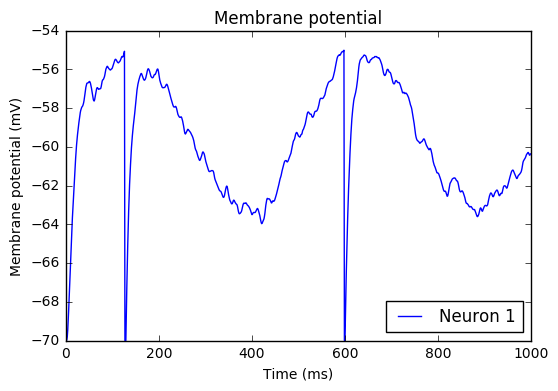

In [1]:
%matplotlib inline
import nest
import nest.voltage_trace
nest.ResetKernel()
neuron = nest.Create('iaf_psc_alpha')
sine = nest.Create('ac_generator', 1,
                   {'amplitude': 100.0,
                    'frequency': 2.0})
noise = nest.Create('poisson_generator', 2,
                    [{'rate': 70000.0},
                     {'rate': 20000.0}])
voltmeter = nest.Create('voltmeter', 1,
                        {'withgid': True})
nest.Connect(sine, neuron)
nest.Connect(voltmeter, neuron)
nest.Connect(noise[:1], neuron, syn_spec={'weight': 1.0, 'delay': 1.0})
nest.Connect(noise[1:], neuron, syn_spec={'weight': -1.0, 'delay': 1.0})
nest.Simulate(1000.0)
nest.voltage_trace.from_device(voltmeter);

We will now go through the simulation script and explain the
individual steps. The first two lines `import` the modules `nest` and its sub-module `voltage_trace`. The `nest` module must be imported in every interactive session
and in every Python script in which you wish to use NEST. NEST is a
C++ library that provides a simulation kernel, many neuron and synapse
models, and the simulation language interpreter SLI. The library which
links the NEST simulation language interpreter to the Python
interpreter is called PyNEST <cite data-cite="Eppler09_12">(Eppler et al. 2009)</cite>. 

Importing `nest` as shown above puts all NEST commands in
the *namespace* `nest`. Consequently, all commands must
be prefixed with the name of this namespace.
 
Next we use the command `Create`
to produce one node of the type `iaf_psc_alpha`. As you see in subsequent lines, `Create` is used for all node types.
The first argument, `'iaf_psc_alpha'`, is a string, denoting
the type of node that you want to create.
The second parameter of `Create` is an integer representing
the number of nodes you want to create. Thus, whether you want one neuron
or 100,000, you only need to call `Create` once.
`nest.Models()` provides a list of all available node and
connection models.

The third parameter is either a dictionary or a list of dictionaries,
specifying the parameter settings for the created nodes. If only one
dictionary is given, the same parameters are used for all created
nodes. If an array of dictionaries is given, they are used in order
and their number must match the number of created nodes. This variant
of `Create` is to set the parameters
for the Poisson noise generator, the sine generator (for the
alternating current), and the voltmeter. All parameters of a model
that are not set explicitly are initialized with default values. You
can display them with
`nest.GetDefaults(model_name)`.
Note that only the first
parameter of `Create` is mandatory. 

`Create` returns a list of integers, the  global
identifiers (or GID for short) of each node created. The GIDs are
assigned in the order in which nodes are created. The first node is
assigned GID 1, the second node GID 2, and so on.

After creating the neuron, sine and noise generators, and voltmeter, we connect the nodes. First we connect the sine generator and the voltmeter
to the neuron. The command `Connect` takes two or more
arguments. The first argument is a list of source nodes. The second
argument is a list of target nodes. `Connect` iterates these
two lists and connects the corresponding pairs.

A node appears in the source position of `Connect` if it sends events
to the target node. In our example, the sine generator is in the
source position because it injects an alternating current into the
neuron. The voltmeter is in the source position because it polls the
membrane potential of the neuron. Other devices may be in the target
position, e.g., the spike detector which receives spike events from a
neuron. If in doubt about the order, consult the documentation of the
respective nodes using NEST's help system. For example, to read the
documentation of the ac\_generator you can type
`nest.help('ac_generator')`. 
Dismiss the help by typing `q`.

Next, we use the command `Connect` with the
`syn_spec` parameter to connect the
two Poisson generators to the neuron. In this example the synapse
specification `syn_spec` provides only weight and delay
values, in this case $\pm 1$ pA input current amplitude and $1$ ms
delay. We will see more advanced uses of  `syn_spec` below.

After connecting the nodes, the network is ready. We call the NEST function `Simulate` which runs the
network for 1000 milliseconds. The function returns after the
simulation is finished. Then, function `voltage_trace` is
called to plot the membrane potential of the neuron. If you are
running the script for the first time, you may have to tell Python to display
the figure by typing `pylab.show()`.

If you want to inspect how your network looks so far, you can print
it using the command `PrintNodes()`:

In [2]:
nest.PrintNodes()

1      iaf_psc_alpha
2      ac_generator
3 .. 4 poisson_generator
5      voltmeter


If you run the example a second time, NEST will leave the existing
nodes intact and will create a second instance for each node. To start
a new NEST session without leaving Python, you can call
`nest.ResetKernel()`. This function will erase the existing
network so that you can start from scratch.

# Example 1: A sparsely connected recurrent network



Next we discuss a model of activity dynamics in a local cortical
network proposed by <cite data-cite="Brunel00">Brunel (2000)</cite>. We only describe those parts of
the model which are necessary to understand its NEST
implementation. Please refer to the original paper for further details.

The local cortical network consists of two neuron populations: a
population of $N_E$ excitatory neurons and a population of $N_I$
inhibitory neurons. To mimic the cortical ratio of 80% excitatory neurons
and 20% inhibitory neurons, we assume that $N_E=$ 8000 and $N_I=$ 2000. Thus,
our local network has a total of 10,000 neurons.

For both the excitatory and the inhibitory population, we use the same
integrate-and-fire neuron model with current-based synapses. Incoming
excitatory and inhibitory spikes displace the membrane potential $V_m$
by $J_{E}$ and $J_I$, respectively. If $V_m$ reaches the threshold
value $V_{\text{th}}$, the membrane potential is reset to $V_{\text{reset}}$,
a spike is sent with delay $D=$ 1.5 ms to all post-synaptic
neurons, and the neuron remains refractory for $\tau_{\text{rp}}=$ 2.0 ms.

The neurons are mutually connected with a probability of
10%. Specifically, each neuron receives input from $C_{E}= 0.1 \cdot N_{E}$ excitatory and $C_I=0.1\cdot N_{I}$ inhibitory neurons (see figure below). The inhibitory synaptic weights
$J_I$ are chosen with respect to the excitatory synaptic weights $J_E$
such that 
$J_I = -g \cdot J_E$, 
with $g=$ 5.0 in this example.

<table class="image">
<caption align="bottom">Sketch of the network model proposed by <cite data-cite="Brunel00">Brunel (2000)</cite>. The network consists of three populations: $N_E$ excitatory neurons (circle labelled E), $N_I$ inhibitory neurons (circle labelled I), and a population of identical, independent Poisson processes (PGs) representing activity from outside the network. Arrows represent connections between the network nodes. Triangular arrow-heads represent excitatory and round arrow-heads represent inhibitory connections. The numbers at the start and end of each arrow indicate the multiplicity of the connection.</caption>
<tr><td><img src="figures/brunel_detailed_external_single2.jpg" alt="Brunel detailed network"/></td></tr>
</table>

In addition to the sparse recurrent inputs from within the local
network, each neuron receives randomly timed excitatory input, mimicking 
the input from the rest of cortex. The random input is modelled as $C_E$
independent and identically distributed Poisson processes with rate
$\nu_{\text{ext}}$, or equivalently, by a single Poisson process with rate 
$C_E \cdot \nu_{\text{ext}}$. Here, we set $\nu_{\text{ext}}$ to twice the 
rate $\nu_{\text{th}}$ that is needed to drive a neuron to threshold 
asymptotically. The details of the model are summarized in the tables below.

In the resulting plot you should see a raster plot of 50
excitatory neurons during the first 300 ms of simulated time. Time is
shown along the x-axis, neuron ID along the y-axis. At $t=0$, all
neurons are in the same state $V_m=0$ and hence there is no spiking
activity. The external stimulus rapidly drives the membrane potentials
towards the threshold. Due to the random nature of the external
stimulus, not all the neurons reach the threshold at the same
time. After a few milliseconds, the neurons start to spike irregularly at
roughly 40 spikes/s. In the original paper, this network
state is called the *asynchronous irregular state* <cite data-cite="Brunel00">(Brunel, 2000)</cite>.


### Summary of the network model
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-header{vertical-align:top}
.tg .tg-yw4l{vertical-align:top}

</style>
<table class="tg" width=90%>
  <tr>
    <th class="tg-header" style="font-weight:bold;background-color:#000000;color:#ffffff;" colspan="2">A: Model Summary<br></th>
  </tr>
  <tr>
    <td class="tg-yw4l">Populations</td>
    <td class="tg-yw4l">Three: excitatory, inhibitory, external input</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Topology</td>
    <td class="tg-yw4l">—</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Connectivity</td>
    <td class="tg-yw4l">Random convergent connections with probability $P=0.1$ and fixed in-degree of $C_E=P N_E$ and $C_I=P N_I$.</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Neuron model</td>
    <td class="tg-yw4l">Leaky integrate-and-fire, fixed voltage threshold, fixed absolute refractory time (voltage clamp).</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Channel models</td>
    <td class="tg-yw4l">—</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Synapse model</td>
    <td class="tg-yw4l">$\delta$-current inputs (discontinuous,voltage jumps)</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Plasticity</td>
    <td class="tg-yw4l">—</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Input</td>
    <td class="tg-yw4l">Independent fixed-rate Poisson spike trains to all neurons</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Measurements</td>
    <td class="tg-yw4l">Spike activity</td>
  </tr>
</table>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-iuc6{font-weight:bold}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg" width=90%>
  <tr>
    <th class="tg" style="font-weight:bold;background-color:#000000;color:#ffffff;" colspan="3">B: Populations<br></th>
  </tr>
  <tr>
    <td class="tg-iuc6">**Name**</td>
    <td class="tg-iuc6">**Elements**</td>
    <td class="tg-iuc6">**Size**</td>
  </tr>
  <tr>
    <td class="tg-031e">nodes_E</td>
    <td class="tg-031e">`iaf_psc_delta` neuron<br></td>
    <td class="tg-yw4l">$N_{\text{E}} = 4N_{\text{I}}$</td>
  </tr>
  <tr>
    <td class="tg-031e">nodes_I</td>
    <td class="tg-031e">`iaf_psc_delta` neuron<br></td>
    <td class="tg-yw4l">$N_{\text{I}}$</td>
  </tr>
  <tr>
    <td class="tg-yw4l">noise</td>
    <td class="tg-yw4l">Poisson generator<br></td>
    <td class="tg-yw4l">1</td>
  </tr>
</table>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-e3zv{font-weight:bold}
.tg .tg-hgcj{font-weight:bold;text-align:center}
.tg .tg-9hbo{font-weight:bold;vertical-align:top}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg" width=90%>
  <tr>
    <th class="tg" style="font-weight:bold;background-color:#000000;color:#ffffff;" colspan="4" >C: Connectivity<br></th>
  </tr>
  <tr>
    <td class="tg-e3zv">**Name**</td>
    <td class="tg-e3zv">**Source**</td>
    <td class="tg-9hbo">**Target**</td>
    <td class="tg-9hbo">**Pattern**</td>
  </tr>
  <tr>
    <td class="tg-031e">EE</td>
    <td class="tg-031e">nodes_E<br></td>
    <td class="tg-yw4l">nodes_E<br></td>
    <td class="tg-yw4l">Random convergent $C_{\text{E}}\rightarrow 1$, weight $J$, delay $D$</td>
  </tr>
  <tr>
    <td class="tg-031e">IE<br></td>
    <td class="tg-031e">nodes_E<br></td>
    <td class="tg-yw4l">nodes_I<br></td>
    <td class="tg-yw4l">Random convergent $C_{\text{E}}\rightarrow 1$, weight $J$, delay $D$</td>
  </tr>
  <tr>
    <td class="tg-yw4l">EI</td>
    <td class="tg-yw4l">nodes_I</td>
    <td class="tg-yw4l">nodes_E</td>
    <td class="tg-yw4l">Random convergent $C_{\text{I}}\rightarrow 1$, weight $-gJ$, delay $D$</td>
  </tr>
  <tr>
    <td class="tg-yw4l">II</td>
    <td class="tg-yw4l">nodes_I</td>
    <td class="tg-yw4l">nodes_I</td>
    <td class="tg-yw4l">Random convergent $C_{\text{I}}\rightarrow 1$, weight $-gJ$, delay $D$</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Ext</td>
    <td class="tg-yw4l">noise</td>
    <td class="tg-yw4l">nodes_E $\cup$ nodes_I</td>
    <td class="tg-yw4l">Divergent $1 \rightarrow N_{\text{E}} + N_{\text{I}}$, weight $J$, delay $D$</td>
  </tr>
</table>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-e3zv{font-weight:bold}
.tg .tg-hgcj{font-weight:bold;text-align:center}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg" width=90%>
  <tr>
    <th class="tg" style="font-weight:bold;background-color:#000000;color:#ffffff;" colspan="2">D: Neuron and Synapse Model<br></th>
  </tr>
  <tr>
    <td class="tg-031e">**Name**</td>
    <td class="tg-031e">`iaf_psc_delta` neuron<br></td>
  </tr>
  <tr>
    <td class="tg-031e">**Type**<br></td>
    <td class="tg-031e">Leaky integrate- and-fire, $\delta$-current input</td>
  </tr>
  <tr>
    <td class="tg-031e">**Sub-threshold dynamics**<br></td>
    <td class="tg-031e">\begin{equation*}
      \begin{array}{rll}
      \tau_m \dot{V}_m(t) = & -V_m(t) + R_m I(t) &\text{if not refractory}\; (t > t^*+\tau_{\text{rp}}) \\[1ex]
      V_m(t) = & V_{\text{r}} & \text{while refractory}\; (t^*<t\leq t^*+\tau_{\text{rp}}) \\[2ex]
      I(t) = & {\frac{\tau_m}{R_m} \sum_{\tilde{t}} w
        \delta(t-(\tilde{t}+D))}
      \end{array}
    \end{equation*}<br></td>
  </tr>
  <tr>
    <td class="tg-yw4l">**Spiking**<br></td>
    <td class="tg-yw4l">If $V_m(t-)<V_{\theta} \wedge V_m(t+)\geq V_{\theta}$<br>&emsp;1. set $t^* = t$<br>&emsp;2. emit spike with time-stamp $t^*$<br></td>
  </tr>
</table>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-e3zv{font-weight:bold}
.tg .tg-hgcj{font-weight:bold;text-align:center}
</style>
<table class="tg" width=90%>
  <tr>
    <th class="tg" style="font-weight:bold;background-color:#000000;color:#ffffff;" colspan="2">E: Input<br></th>
  </tr>
  <tr>
    <td class="tg-031e">**Type**<br></td>
    <td class="tg-031e">**Description**<br></td>
  </tr>
  <tr>
    <td class="tg-031e">Poisson generator<br></td>
    <td class="tg-031e">Fixed rate $\nu_{\text{ext}} \cdot C_{\text{E}}$, one generator providing independent input to each target neuron</td>
  </tr>
</table>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-e3zv{font-weight:bold}
.tg .tg-hgcj{font-weight:bold;text-align:center}
</style>
<table class="tg" width=90%>
  <tr>
    <th class="tg" style="font-weight:bold;background-color:#000000;color:#ffffff;" colspan="2">F: Measurements<br></th>
  </tr>
  <tr>
    <td class="tg-031e" colspan="2">Spike activity as raster plots, rates and ''global frequencies'', no details given</td>
  </tr>
</table>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top;}
</style>
<table class="tg" width=90%>
  <tr>
    <th class="tg" style="font-weight:bold;background-color:#000000;color:#ffffff;" colspan="2">G: Network Parameters<br></th>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border-right-style:hidden">**Parameter**</td>
    <td class="tg-yw4l" style="text-align:right;">**Value**<br></td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border-right-style:hidden">Number of excitatory neurons $N_E$</td>
    <td class="tg-yw4l" style="text-align:right;">8000</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border-right-style:hidden;border-top-style:hidden">Number of inhibitory neurons $N_I$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">2000</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border-right-style:hidden;border-top-style:hidden">Excitatory synapses per neuron $C_E$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">800</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border-right-style:hidden;border-top-style:hidden">Inhibitory synapses per neuron $C_I$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">200</td>
  </tr>
  <tr>
  </tr>
</table>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-e3zv{font-weight:bold}
.tg .tg-hgcj{font-weight:bold;text-align:center}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg" width=90%>
  <tr>
    <th class="tg" style="font-weight:bold;background-color:#000000;color:#ffffff;" colspan="2">H: Neuron Parameters<br></th>
  </tr>
  <tr>
    <td class="tg-031e" style="border-right-style:hidden">**Parameter**</td>
    <td class="tg-031e" style="text-align:right;">**Value**<br></td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border-right-style:hidden">Membrane time constant $\tau_m$</td>
    <td class="tg-yw4l" style="text-align:right;">20 ms</td>
  </tr>
  <tr>
    <td class="tg-yw4l"style="border-right-style:hidden;border-top-style:hidden">Refractory period $\tau_{\text{rp}}$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">2 ms</td>
  </tr>
  <tr>
    <td class="tg-yw4l"style="border-right-style:hidden;border-top-style:hidden">Firing threshold $V_{\text{th}}$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">20 mV</td>
  </tr>
  <tr>
    <td class="tg-yw4l"style="border-right-style:hidden;border-top-style:hidden">Membrane capacitance $C_m$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">1 pF</td>
  </tr>
  <tr>
    <td class="tg-yw4l"style="border-right-style:hidden;border-top-style:hidden">Resting potential $V_E$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">0 mV</td>
  </tr>
  <tr>
    <td class="tg-yw4l"style="border-right-style:hidden;border-top-style:hidden">Reset potential $V_{\text{reset}}$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">10 mV</td>
  </tr>
  <tr>
    <td class="tg-yw4l"style="border-right-style:hidden;border-top-style:hidden">Excitatory PSP amplitude $J_E$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">0.1 mV</td>
  </tr>
  <tr>
    <td class="tg-yw4l"style="border-right-style:hidden;border-top-style:hidden">Inhibitory PSP amplitude $J_I$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">-0.5 mV</td>
  </tr>
  <tr>
    <td class="tg-yw4l"style="border-right-style:hidden;border-top-style:hidden">Synaptic delay $D$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">1.5 ms</td>
  </tr>
  <tr>
    <td class="tg-yw4l"style="border-right-style:hidden;border-top-style:hidden">Background rate $\eta$</td>
    <td class="tg-yw4l" style="text-align:right;border-top-style:hidden;">2.0</td>
  </tr>
  <tr>
  </tr>
</table>


## NEST Implementation

We now show how this model is implemented in NEST. Along the way, we
explain the required steps and NEST commands in more detail so that
you can apply them to your own models.

### Preparations
The first three lines import NEST, a NEST module for raster plots, and
the plotting package `pylab`. We then assign the various model
parameters to variables.

In [ ]:
import nest
import nest.raster_plot
import pylab
nest.ResetKernel()
g = 5.0
eta = 2.0
delay = 1.5
tau_m = 20.0
V_th = 20.0
N_E = 8000
N_I = 2000
N_neurons = N_E + N_I
C_E = int(N_E / 10)
C_I = int(N_I / 10)
J_E = 0.1
J_I = -g * J_E
nu_ex = eta * V_th / (J_E * C_E * tau_m)
p_rate = 1000.0 * nu_ex * C_E

In the second to last line, we compute the firing rate
`nu_ex` ($\nu_{\text{ext}}$) of a neuron in the external population. We define
`nu_ex` as the product of a constant `eta` times
the threshold rate $\nu_{\text{th}}$, i.e. the steady state firing
rate which is needed to bring a neuron to threshold. The value of the
scaling constant is defined with `eta`.

In the final line, we compute the combined input rate due to the
external population. With $C_E$ incoming synapses per neuron, the total rate is
simply the product `nu_ex*C_E`. The factor 1000.0 in the
product changes the units from spikes per ms to spikes per second.

Next, we prepare the simulation kernel of NEST

In [ ]:
nest.SetKernelStatus({'print_time': True})

The command `SetKernelStatus`
modifies parameters of the simulation kernel. The argument is a Python
dictionary with *key*:*value* pairs. Here, we set the NEST
kernel to print the progress of the simulation time during simulation. Note that the progress is output only to the terminal.

### Creating neurons and devices

As a rule of thumb, we recommend that you create all elements in your
network, i.e., neurons, stimulating devices and recording devices
first, before creating any connections. 

In [ ]:
nest.SetDefaults('iaf_psc_delta', 
                 {'C_m': 1.0,
                  'tau_m': tau_m,
                  't_ref': 2.0,
                  'E_L': 0.0,
                  'V_th': V_th,
                  'V_reset': 10.0})

Here we change the parameters of the neuron model we want to use from the
built-in values to the defaults for our investigation.
`SetDefaults` expects two parameters. The first is a string,
naming the model for which the default parameters should be
changed. Our neuron model for this simulation is the simplest
integrate-and-fire model in NEST's repertoire:
`'iaf_psc_delta'`. The second parameter is a dictionary with
parameters and their new values, entries separated by commas. All
parameter values are taken from Brunel's paper <cite data-cite="Brunel00">(Brunel, 2000)</cite> and we
insert them directly for brevity. Only the membrane time constant
`tau_m` and the threshold potential `V_th` are
read from variables, because these values are needed in several places.

In [ ]:
nodes = nest.Create('iaf_psc_delta', N_neurons)
nodes_E = nodes[:N_E]
nodes_I = nodes[N_E:]

noise = nest.Create('poisson_generator', 1, {'rate': p_rate})

nest.SetDefaults('spike_detector', {'to_file': True})

spikes = nest.Create('spike_detector', 2,
                     [{'label': 'brunel-py-ex'},
                      {'label': 'brunel-py-in'}])
spikes_E = spikes[:1]
spikes_I = spikes[1:]

As before we create the neurons with `Create`, which returns a list of the global IDs which
are consecutive numbers from 1 to `N_neurons`. 
We split this range into excitatory and inhibitory neurons. We then select the first `N_E`
elements from the list `nodes` and assign them to the
variable `nodes_E`. This list now holds the GIDs of the
excitatory neurons. 

Similarly, in the next line, we assign the range from position
`N_E` to the end of the list to the variable
`nodes_I`. This list now holds the GIDs of all inhibitory
neurons. The selection is carried out using standard Python list commands. You
may want to consult the Python documentation for more details.

Next, we create and connect the external population and some devices
to measure the spiking activity in the network.

We create a device known as a
`poisson_generator`, which produces a spike train governed
by a Poisson process at a given rate. We use the third parameter of
`Create` to initialize the rate of the Poisson process to
the population rate `p_rate` which we have previously computed.

If a Poisson generator is connected to $n$ targets, it generates $n$
independent and identically distributed spike trains. Thus, we only
need one generator to model an entire population of randomly firing
neurons.

To observe how the neurons in the recurrent network respond to the 
random spikes from the external population, we create two spike detectors.
By default, spike detectors record to memory but not to file. We override this default behaviour to also record
to file. Then we create one detector for the 
excitatory neurons and one for the inhibitory neurons. 
The default file names are automatically generated from the device type and
its global ID. We use the third argument of `Create` to give each 
spike detector a `'label'`, which will be part of the name of the 
output file written by the detector. Since two devices are created, we supply
a list of dictionaries.

In the second to last line, we store the GID of the first spike
detector in a one-element list and assign it to the variable
`spikes_E`. In the next line, we do the same for the second
spike detector that is dedicated to the inhibitory population.

### Connecting the network

Once all network elements are in place, we connect them.


In [ ]:
nest.CopyModel('static_synapse_hom_w', 
               'excitatory',
               {'weight': J_E, 
                'delay': delay})
nest.Connect(nodes_E, nodes, 
             {'rule': 'fixed_indegree', 
              'indegree': C_E},
             'excitatory')          
nest.CopyModel('static_synapse_hom_w', 
               'inhibitory',
               {'weight': J_I, 
                'delay':delay})
nest.Connect(nodes_I, nodes,
             {'rule': 'fixed_indegree', 
              'indegree': C_I},
             'inhibitory')

We create a new connection
type `'excitatory'` by copying the built-in connection type
`'static_synapse_hom_w'` while changing its default values
for *weight* and *delay*. The command `CopyModel`
expects either two or three arguments: the name of an existing neuron
or synapse model, the name of the new model, and optionally a
dictionary with the new default values of the new model.

The connection type `'static_synapse_hom_w'` uses the same
values of weight for all synapses. This saves memory for
networks in which these values are identical for all connections. Later (in 'Randomness in NEST') we will use a different connection model to
implement randomized weights and delays.

Having created and parameterized an appropriate synapse model, we draw
the incoming excitatory connections for each neuron. The function
`Connect`  expects four arguments: a list of
source nodes, a list of target nodes, a connection rule, and a synapse
specification. Some connection rules, in particular
`'one_to_one'` and `'all_to_all'` require no
parameters and can be specified as strings. All other connection rules
must be specified as a dictionary, which at least must contain the key
`'rule'` specifying a connection rule;
`nest.ConnectionRules()` shows all connection rules. The
remaining dictionary entries depend on the particular rule. We use the
`'fixed_indegree'` rule, which creates exactly
`indegree` connections to each target neuron; in previous
versions of NEST, this connectivity was provided by
`RandomConvergentConnect`. 

The final argument specifies the synapse model to be used, here the
`'excitatory'` model we defined previously.


In the final lines we
repeat the same steps for the inhibitory connections: we create a new
connection type and draw the incoming inhibitory connections for all neurons.

In [ ]:
nest.Connect(noise, nodes, syn_spec='excitatory')

N_rec = 50
nest.Connect(nodes_E[:N_rec], spikes_E)
nest.Connect(nodes_I[:N_rec], spikes_I)

Here we use `Connect` to
connect the Poisson generator to all nodes of the local network. Since
these connections are excitatory, we use the `'excitatory'`
connection type. Finally, we connect a subset of excitatory and
inhibitory neurons to the spike detectors to record from them. If no connection rule
is given, `Connect` connects all sources to all targets (`all_to_all` rule), 
i.e., the noise generator is connected to all neurons 
(previously `DivergentConnect`), while in the second to last line, all recorded 
excitatory neurons are connected to the `spikes_E` spike detector 
(previously `ConvergentConnect`).

Our network consists of 10,000 neurons, all of which have the same
activity statistics due to the random connectivity. Thus, it suffices
to record from a representative sample of neurons, rather than from
the entire network. Here, we choose to record from 50 neurons and
assign this number to the variable `N_rec`. We then connect
the first 50 excitatory neurons to their spike detector. Again, we use
standard Python list operations to select `N_rec` neurons
from the list of all excitatory nodes. Alternatively, we could select
50 neurons at random, but since the neuron order has no meaning in
this model, the two approaches would yield qualitatively the same
results. Finally, we repeat this step for the inhibitory neurons.

### Simulating the network

Now everything is set up and we can run the simulation.

In [ ]:
simtime = 300
nest.Simulate(simtime)
ex_events, in_events = nest.GetStatus(spikes, 'n_events')
events_to_rate = 1000. / simtime / N_rec
rate_ex = ex_events * events_to_rate
print('Excitatory rate: {:.2f} Hz'.format(rate_ex))
rate_in = in_events * events_to_rate
print('Inhibitory rate: {:.2f} Hz'.format(rate_in))
nest.raster_plot.from_device(spikes_E, hist=True); 

First we select a simulation time of
300 milliseconds and assign it to a variable. Next, we call the NEST
command `Simulate` to run the simulation for 300 ms. During
simulation, the Poisson generators send spikes into the network
and cause the neurons to fire. The spike detectors receive spikes
from the neurons and write them to a file and to memory.

When the function returns, the simulation time has progressed by
300 ms. You can call `Simulate` as often as you like and
with different arguments. NEST will resume the simulation at the point
where it was last stopped. Thus, you can partition your simulation time
into small epochs to regularly inspect the progress of your model.

After the simulation is finished, we compute the firing rate of the
excitatory neurons and the inhibitory
neurons. Finally, we call the NEST
function `raster_plot` to produce the raster plot. `raster_plot` has two
modes. `raster_plot.from_device` expects the global ID of a
spike detector.  `raster_plot.from_file` expects the name of
a data file. This is useful to plot data without repeating a
simulation.


# Parallel simulation

Large network models often require too much time or computer memory to
be conveniently simulated on a single computer. For example, if we increase the number of
neurons in the previous model to 100,000, there will be a total of
$10^9$ connections, which won't fit into the memory of most computers.
Similarly, if we use plastic synapses (see Example 3: plastic networks) and run the model for minutes or hours of
simulated time, the execution times become uncomfortably long.
 
To address this issue, NEST has two modes of parallelization:
multi-threading and distribution. Multi-threaded and distributed
simulation can be used in isolation or in combination <cite data-cite="Ples:2007(672)">(Plesser et al., 2007)</cite>
, and both modes allow you to connect and run
networks more quickly than in the serial case.  

Multi-threading means that NEST uses all
available processors or cores of the computer. Today, most desktop
computers and even laptops have at least two processing cores. Thus,
you can use NEST's multi-threaded mode to make your simulations
execute more quickly whilst still maintaining the convenience of
interactive sessions. Since a given computer has a fixed memory size,
multi-threaded simulation can only reduce execution times. It cannot
solve the problem that large models exhaust the computer's memory.

Distribution means that NEST uses
many computers in a network or computer cluster. Since each computer
contributes memory, distributed simulation allows you to simulate
models that are too large for a single computer. However, in
distributed mode it is not currently possible to use NEST
interactively.

In most cases, writing a simulation script to be run in parallel is as
easy as writing one to be executed on a single processor. Only minimal
changes are required, as described below, and you can ignore the fact
that the simulation is actually executed by more than one core or
computer. However, in some cases your knowledge about the distributed
nature of the simulation can help you improve efficiency even
further. For example, in the distributed mode, all computers execute
the same simulation script. We can improve performance if the
script running on a specific computer only tries to execute commands
relating to nodes that are represented on the
same computer. An example of this technique is shown below in Example 2.

To switch NEST into
multi-threaded mode, you only have to add one line to your simulation
script:

In [ ]:
nest.ResetKernel()
n = 4  # number of threads
nest.SetKernelStatus({'local_num_threads': n})

Here, `n` is the number of threads you want to use. It is
important that you set the number of threads *before* you create
any nodes. If you try to change the number of threads after nodes were
created, NEST will issue an error.

A good choice for the number of threads is the number of cores or
processors on your computer. If your processor supports
hyperthreading, you can select an even higher number of threads.

The distributed mode of NEST is particularly useful for large simulations
for which not only the processing speed, but also the memory of a single
computer are insufficient.  The distributed mode of NEST uses the
Message Passing Interface <cite data-cite="MPI2009">(MPI Forum, 2009)</cite>, a library that must be
installed on your computer network when you install NEST. For details,
please refer to NEST documentation at [www.nest-simulator.org](http://www.nest-simulator.org/documentation/).

The distributed mode of NEST is also easy to use. All you need to do
is start NEST with the MPI command `mpirun`:

`mpirun -np m python script.py`

where `m` is the number of MPI processes that should be
started. One sensible choice for `m` is the total number of
cores available on the cluster. Another reasonable choice is the
number of physically distinct machines, utilizing their cores through
multithreading as described above. This can be useful on clusters of
multi-core computers. 

In NEST, processes and threads are both mapped to *virtual processes* <cite data-cite="Ples:2007(672)">(Plesser et al. 2007)</cite> . If a
simulation is started with `m` MPI processes and
`n`  threads on each process, then there are
`m`$\times$`n`  virtual processes. You can obtain
the number of virtual processes in a simulation with

In [ ]:
nest.GetKernelStatus('total_num_virtual_procs')

The virtual process concept is reflected in the labelling of output
files. For example, the data files for the excitatory spikes produced
by the network discussed here follow the form
`brunel-py-ex-x-y.gdf`, where `x` is the ID of the
data recording node and `y` is the ID of the virtual
process.

# Randomness in NEST

NEST has built-in random number sources that can be used for tasks
such as randomizing spike trains or network connectivity. In this
section, we discuss some of the issues related to the use of random
numbers in parallel simulations. In example 2, we illustrate how to randomize
parameters in a network.

Let us first consider the case that a simulation script does not
explicitly generate random numbers. In this case, NEST produces
identical simulation results for a given number of virtual processes,
irrespective of how the virtual processes are partitioned into threads
and MPI processes. The only difference between the output of two
simulations with different configurations of threads and processes
resulting in the same number of virtual processes is the result of
query commands such as `GetStatus`. These commands 
gather data over threads on the local machine, but not over remote
machines.

In the case that random numbers are explicitly generated in the
simulation script, more care must be taken to produce results that are
independent of the parallel configuration. Consider, for example, a
simulation where two threads have to draw a random number from a
single random number generator. Since only one thread can access the
random number generator at a time, the outcome of the simulation will
depend on the access order.

Ideally, all random numbers in a simulation should come from a single
source. In a serial simulation this is trivial to implement, but in
parallel simulations this would require shipping a large number of
random numbers from a central random number generator (RNG) to all
processes. This is impractical.  Therefore, NEST uses one independent
random number generator on each
virtual process. Not all random number generators can be used in
parallel simulations, because many cannot reliably produce
uncorrelated parallel streams. Fortunately, recent years have seen
great progress in RNG research and there is a range of random number
generators that can be used with great fidelity in parallel
applications.

Based on this knowledge, each virtual process (VP) in NEST has its own
RNG. Numbers from these RNGs are used to

* choose random connections
* create random spike trains (e.g., `poisson_generator`)
  or random currents
  (e.g., `noise_generator`).

In order to randomize model parameters in a PyNEST script, it is
convenient to use the random number generators provided by
NumPy. To ensure consistent results for a given number
of virtual processes, each virtual process should use a separate
Python RNG. Thus, in a simulation running on $N_{vp}$ virtual processes,
there should be $2N_{vp}+1$ RNGs in total:

* the global NEST RNG;
* one RNG per VP in NEST;
* one RNG per VP in Python.

We need to provide separate seed values for each of these generators.
Modern random number generators work equally well for all seed
values. We thus suggest the following approach to choosing seeds: For
each simulation run, choose a master seed $msd$ and seed the RNGs
with seeds $msd$, $msd+1$, $\dots$ $msd+2N_{vp}$. Any two master seeds must
differ by at least $2N_{vp}+1$ to avoid correlations between simulations.

By default, NEST uses Knuth's lagged Fibonacci RNG, which has the nice
property that each seed value provides a different sequence of
some $2^{70}$ random numbers <cite data-cite="Knut:Art(2)(1998)">(Knuth, 1998, Ch. 3.6)</cite>. Python
uses the Mersenne Twister MT19937 generator <cite data-cite="Mats:1998(3)">(Matsumoto and Nishimura, 1998)</cite>,
which provides no explicit guarantees, but given the enormous state
space of this generator it appears astronomically unlikely that
neighbouring integer seeds would yield overlapping number
sequences. For a recent overview of RNGs, see <cite data-cite="Lecu:2007(22)">L'Ecuyer and Simard (2007)</cite>. For general introductions to random number
generation, see <cite data-cite="Gent:Rand(2003)">Gentle (2003)</cite>, <cite data-cite="Knut:Art(2)(1998)">Knuth (1998, Ch. 3)</cite> or <cite data-cite="Ples:2010(399)">Plesser (2010)</cite>.


# Example 2: Randomizing neurons and synapses


Let us now consider how to randomize some neuron and synapse
parameters in the sparsely connected network model introduced in Example 1. We shall 

* explicitly seed the random number generators;
* randomize the initial membrane potential of all neurons;
* randomize the weights of the recurrent excitatory connections. 

We begin by setting up the parameters

In [ ]:
import numpy
import nest
nest.ResetKernel()
# Network parameters. These are given in Brunel (2000) J.Comp.Neuro.
g = 5.0  # Ratio of IPSP to EPSP amplitude: J_I/J_E
eta = 2.0  # rate of external population in multiples of threshold rate
delay = 1.5  # synaptic delay in ms
tau_m = 20.0  # Membrane time constant in mV
V_th = 20.0  # Spike threshold in mV

N_E = 8000
N_I = 2000
N_neurons = N_E + N_I

C_E = int(N_E / 10)  # number of excitatory synapses per neuron
C_I = int(N_I / 10)  # number of inhibitory synapses per neuron

J_E = 0.1
J_I = -g * J_E

nu_ex = eta * V_th / (J_E * C_E * tau_m)  # rate of an external neuron in ms^-1
p_rate = 1000.0 * nu_ex * C_E  # rate of the external population in s^-1

# Set parameters of the NEST simulation kernel
nest.SetKernelStatus({'print_time': True,
                      'local_num_threads': 2})

So far the code is similar to Example 1, but now we insert code to seed the
random number generators:

In [ ]:
# Create and seed RNGs
msd = 1000   # master seed
n_vp = nest.GetKernelStatus('total_num_virtual_procs')
msdrange1 = range(msd, msd + n_vp)
pyrngs = [numpy.random.RandomState(s) for s in msdrange1]
msdrange2 = range(msd + n_vp + 1, msd + 1 + 2 * n_vp)
nest.SetKernelStatus({'grng_seed': msd + n_vp,
                      'rng_seeds': msdrange2})

We first define the master seed `msd` and then obtain the number of
virtual processes `n_vp`.  Then we create a list of `n_vp` NumPy random number generators
with seeds `msd`, `msd+1`, $\dots$
`msd+n_vp-1`. The next two lines set new seeds for the
built-in NEST RNGs: the global RNG is seeded with
`msd+n_vp`, the per-virtual-process RNGs with
`msd+n_vp+1`, $\dots$, `msd+2*n_vp`. Note that the
seeds for the per-virtual-process RNGs must always be passed as a
list, even in a serial simulation.

Then we create the nodes

In [ ]:
nest.SetDefaults('iaf_psc_delta',
                 {'C_m': 1.0,
                  'tau_m': tau_m,
                  't_ref': 2.0,
                  'E_L': 0.0,
                  'V_th': V_th,
                  'V_reset': 10.0})
nodes = nest.Create('iaf_psc_delta', N_neurons)
nodes_E = nodes[:N_E]
nodes_I = nodes[N_E:]

noise = nest.Create('poisson_generator', 1, {'rate': p_rate})

spikes = nest.Create('spike_detector', 2,
                     [{'label': 'brunel-py-ex'},
                      {'label': 'brunel-py-in'}])
spikes_E = spikes[:1]
spikes_I = spikes[1:]

After creating the neurons as before, we insert the following code to randomize the membrane potential
of all neurons:

In [ ]:
node_info = nest.GetStatus(nodes)
local_nodes = [(ni['global_id'], ni['vp'])
               for ni in node_info if ni['local']]
for gid, vp in local_nodes:
    nest.SetStatus([gid], {'V_m': pyrngs[vp].uniform(-V_th, V_th)})

In this code, we meet the concept of *local* nodes for the first
time (Plesser et al. 2007). In serial and multi-threaded
simulations, all nodes are local. In an MPI-based simulation with $m$
MPI processes, each MPI process represents and is responsible for
updating (approximately) $1/m$-th of all nodes—these are the local
nodes for each process. We obtain status 
information for each node; for local nodes, this will be full information, 
for non-local nodes this will only be minimal information. We then use a list
 comprehension to create
a list of `gid` and `vp` tuples for all local
nodes. The `for`-loop then iterates over this list and draws
for each node a membrane potential value uniformly distributed in
$[-V_{\text{th}}, V_{\text{th}})$, i.e., $[-20\text{mV},
20\text{mV})$. We draw the initial membrane potential for each node
from the NumPy RNG assigned to the virtual process `vp`
responsible for updating that node.

As the next step, we create excitatory recurrent connections with the
same connection rule as in the original script, but with randomized
weights.

In [ ]:
nest.CopyModel('static_synapse', 'excitatory')
nest.Connect(nodes_E, nodes,
             {'rule': 'fixed_indegree',
              'indegree': C_E},
             {'model': 'excitatory',
              'delay': delay,
              'weight': {'distribution': 'uniform',
                         'low': 0.5 * J_E,
                         'high': 1.5 * J_E}})

The first difference to the original is that we base the excitatory
synapse model on the built-in `static_synapse` model instead
of `static_synapse_hom_w`, as the latter implies equal
weights for all synapses. The second difference is that we randomize
the initial weights. To this end, we have replaced the simple synapse
specification `'excitatory'` with a subsequent synapse specification
dictionary. Such
a dictionary must always contain the key `'model'` providing
the synapse model to use. In addition, we specify a fixed delay, and a
distribution from which to draw the weights, here a uniform
distribution over $[J_E/2, 3J_E/2)$. NEST will automatically use the
correct random number generator for each weight. 

To see all available random distributions, please run
`nest.sli_run('rdevdict info')`. To access documentation for
an individual distribution, run, e.g., `nest.help('rdevdict::binomial')`.
These distributions can be
used for all parameters of a synapse.

We then make the rest of the connections.

In [ ]:
nest.CopyModel('static_synapse_hom_w',
               'inhibitory',
               {'weight': J_I,
                'delay': delay})
nest.Connect(nodes_I, nodes,
             {'rule': 'fixed_indegree',
              'indegree': C_I},
             'inhibitory')

# connect one noise generator to all neurons
nest.CopyModel('static_synapse_hom_w',
               'excitatory_input',
               {'weight': J_E,
                'delay': delay})
nest.Connect(noise, nodes, syn_spec='excitatory_input')

# connect all recorded E/I neurons to the respective detector
N_rec = 50  # Number of neurons to record from
nest.Connect(nodes_E[:N_rec], spikes_E)
nest.Connect(nodes_I[:N_rec], spikes_I)

Before starting our simulation, we want to visualize the randomized
initial membrane potentials and weights. To this end, we insert the
following code just before we start the simulation:

In [ ]:
pylab.figure(figsize=(12,3))
pylab.subplot(121)
V_E = nest.GetStatus(nodes_E[:N_rec], 'V_m')
pylab.hist(V_E, bins=10)
pylab.xlabel('Membrane potential V_m [mV]')
pylab.title('Initial distribution of membrane potentials')
pylab.subplot(122)
ex_conns = nest.GetConnections(nodes_E[:N_rec],
                               synapse_model='excitatory')
w = nest.GetStatus(ex_conns, 'weight')
pylab.hist(w, bins=100)
pylab.xlabel('Synaptic weight [pA]')
pylab.title(
    'Distribution of synaptic weights ({:d} synapses)'.format(len(w)));

Here, `nest.GetStatus` retrieves the membrane potentials of all 50
recorded neurons. The data is then displayed as a histogram with 10
bins. 
The function `nest.GetConnections` here finds 
all connections that

* have one of the 50 recorded excitatory neurons as source;
* have any local node as target;
* and are of type `excitatory`.
 
Next, we then use `GetStatus()` to
obtain the weights of these connections. Running the script in a
single MPI process, we record approximately 50,000 weights, which we
display in a histogram with 100 bins.

Note that the code above
will return complete results only when run in a single MPI
process. Otherwise, only data from local neurons or connections with
local targets will be obtained. It is currently not possible to
collect recorded data across MPI processes in NEST. In distributed
simulations, you should thus let recording devices write data to files
and collect the data after the simulation is complete.

Comparing the
raster plot from the simulation with randomized initial membrane
potentials with the same plot for the
original network reveals that the
membrane potential randomization has prevented the synchronous onset
of activity in the network.

We now run the simulation.

In [ ]:
simtime = 300.  # how long shall we simulate [ms]
nest.Simulate(simtime)

As a final point, we make a slight improvement to the rate computation of the original
script. Spike detectors count only spikes from neurons on the local
MPI process. Thus, the original computation is correct only for a
single MPI process. To obtain meaningful results when simulating
on several MPI processes, we count how many of the `N_rec`
recorded nodes are local and use that number to compute the rates:

In [ ]:
events = nest.GetStatus(spikes, 'n_events')

N_rec_local_E = sum(nest.GetStatus(nodes_E[:N_rec], 'local'))
rate_ex = events[0] / simtime * 1000.0 / N_rec_local_E
print('Excitatory rate   : {:.2f} Hz'.format(rate_ex))

N_rec_local_I = sum(nest.GetStatus(nodes_I[:N_rec], 'local'))
rate_in = events[1] / simtime * 1000.0 / N_rec_local_I
print('Inhibitory rate   : {:.2f} Hz'.format(rate_in))

Each MPI process then reports the rate of activity of its locally
recorded nodes.


# Example 3: Plastic Networks

NEST provides synapse models with a variety of short-term and
long-term dynamics. To illustrate this, we extend the sparsely
connected network introduced in Example 1 with
randomized synaptic weights as described in section 'Randomness in NEST' to incorporate spike-timing-dependent plasticity <cite data-cite="Bi98">(Bi and Poo, 1998)</cite> at its recurrent excitatory-excitatory synapses.

We create all nodes and randomize their initial membrane potentials
as before. We then generate a plastic synapse model for the excitatory-excitatory
connections and a static synapse model for the excitatory-inhibitory
connections:

In [ ]:
nest.ResetKernel()
# Synaptic parameters
STDP_alpha = 2.02  # relative strength of STDP depression w.r.t potentiation
STDP_Wmax = 3 * J_E  # maximum weight of plastic synapse

# Simulation parameters
N_vp = 8  # number of virtual processes to use
base_seed = 10000  # increase in intervals of at least 2*n_vp+1
N_rec = 50  # Number of neurons to record from
data2file = True  # whether to record data to file
simtime = 300.  # how long shall we simulate [ms]
# Set parameters of the NEST simulation kernel
nest.SetKernelStatus({'print_time': True,
                      'local_num_threads': 2})

# Create and seed RNGs
ms = 1000  # master seed
n_vp = nest.GetKernelStatus('total_num_virtual_procs')
pyrngs = [numpy.random.RandomState(s) for s in range(ms, ms + n_vp)]
nest.SetKernelStatus({'grng_seed': ms + n_vp,
                      'rng_seeds': range(ms + n_vp + 1, ms + 1 + 2 * n_vp)})

# Create nodes -------------------------------------------------

nest.SetDefaults('iaf_psc_delta',
                 {'C_m': 1.0,
                  'tau_m': tau_m,
                  't_ref': 2.0,
                  'E_L': 0.0,
                  'V_th': V_th,
                  'V_reset': 10.0})

nodes = nest.Create('iaf_psc_delta', N_neurons)
nodes_E = nodes[:N_E]
nodes_I = nodes[N_E:]

noise = nest.Create('poisson_generator', 1, {'rate': p_rate})

spikes = nest.Create('spike_detector', 2,
                     [{'label': 'brunel_py_ex'},
                      {'label': 'brunel_py_in'}])
spikes_E = spikes[:1]
spikes_I = spikes[1:]

# randomize membrane potential
node_info = nest.GetStatus(nodes, ['global_id', 'vp', 'local'])
local_nodes = [(gid, vp) for gid, vp, islocal in node_info if islocal]
for gid, vp in local_nodes:
    nest.SetStatus([gid], {'V_m': pyrngs[vp].uniform(-V_th, V_th)})

nest.CopyModel('stdp_synapse_hom',
               'excitatory_plastic',
               {'alpha': STDP_alpha,
                'Wmax': STDP_Wmax})
nest.CopyModel('static_synapse', 'excitatory_static')

Here, we set the parameters `alpha` and `Wmax`  of
the synapse model but use the default settings for all its other
parameters. The `_hom` suffix in the synapse model name
indicates that all plasticity parameters such as `alpha` and
`Wmax` are shared by all synapses of this model.

We again use `nest.Connect` to create connections with
randomized weights:

In [ ]:
nest.Connect(nodes_E, nodes_E,
             {'rule': 'fixed_indegree',
              'indegree': C_E},
             {'model': 'excitatory_plastic',
              'delay': delay,
              'weight': {'distribution': 'uniform',
                         'low': 0.5 * J_E,
                         'high': 1.5 * J_E}})

nest.Connect(nodes_E, nodes_I,
             {'rule': 'fixed_indegree',
              'indegree': C_E},
             {'model': 'excitatory_static',
              'delay': delay,
              'weight': {'distribution': 'uniform',
                         'low': 0.5 * J_E,
                         'high': 1.5 * J_E}})
nest.CopyModel('static_synapse',
               'inhibitory',
               {'weight': J_I,
                'delay': delay})
nest.Connect(nodes_I, nodes,
             {'rule': 'fixed_indegree',
              'indegree': C_I},
             'inhibitory')

# connect noise generator to all neurons
nest.CopyModel('static_synapse_hom_w',
               'excitatory_input',
               {'weight': J_E,
                'delay': delay})
nest.Connect(noise, nodes, syn_spec='excitatory_input')

# connect all recorded E/I neurons to the respective detector
nest.Connect(nodes_E[:N_rec], spikes_E)
nest.Connect(nodes_I[:N_rec], spikes_I)

# Simulate -----------------------------------------------------

# Visualization of initial membrane potential and initial weight
# distribution only if we run on single MPI process
if nest.NumProcesses() == 1:

    pylab.figure(figsize=(12,3))

    # membrane potential
    V_E = nest.GetStatus(nodes_E[:N_rec], 'V_m')
    V_I = nest.GetStatus(nodes_I[:N_rec], 'V_m')
    pylab.subplot(121)
    pylab.hist([V_E, V_I], bins=10)
    pylab.xlabel('Membrane potential V_m [mV]')
    pylab.legend(('Excitatory', 'Inibitory'))
    pylab.title('Initial distribution of membrane potentials')
    pylab.draw()

    # weight of excitatory connections
    w = nest.GetStatus(nest.GetConnections(nodes_E[:N_rec],
                                           synapse_model='excitatory_plastic'),
                       'weight')

    pylab.subplot(122)
    pylab.hist(w, bins=100)
    pylab.xlabel('Synaptic weight w [pA]')
    pylab.title('Initial distribution of excitatory synaptic weights')
    pylab.draw()

else:
    print('Multiple MPI processes, skipping graphical output')

nest.Simulate(simtime)

events = nest.GetStatus(spikes, 'n_events')

# Before we compute the rates, we need to know how many of the recorded
# neurons are on the local MPI process
N_rec_local_E = sum(nest.GetStatus(nodes_E[:N_rec], 'local'))
rate_ex = events[0] / simtime * 1000.0 / N_rec_local_E
print('Excitatory rate   : {:.2f} Hz'.format(rate_ex))

N_rec_local_I = sum(nest.GetStatus(nodes_I[:N_rec], 'local'))
rate_in = events[1] / simtime * 1000.0 / N_rec_local_I
print('Inhibitory rate   : {:.2f} Hz'.format(rate_in))

After a period of simulation, we can access the plastic synaptic
weights for analysis:

In [ ]:
if nest.NumProcesses() == 1:
    nest.raster_plot.from_device(spikes_E, hist=True)
    # weight of excitatory connections
    w = nest.GetStatus(nest.GetConnections(nodes_E[:N_rec],
                                           synapse_model='excitatory_plastic'),
                       'weight')
    pylab.figure(figsize=(12,4))
    pylab.hist(w, bins=100)
    pylab.xlabel('Synaptic weight [pA]')
    # pylab.savefig('../figures/rand_plas_w.eps')
    # pylab.show()

else:
    print('Multiple MPI processes, skipping graphical output')

Plotting a histogram of the synaptic weights reveals that the initial
uniform distribution has begun to soften, as we can see in the plots resulting from the simulation above. Simulation for a longer period
results in an approximately Gaussian distribution of weights.

# Example 4: Classes and Automatization Techniques

Running the examples line for line is possible in interactive sessions, but if you want to run a
simulation several times, possibly with different parameters, it is
more practical to write a script that can be loaded from Python.

Python offers a number of mechanisms to structure and organize not
only your simulations, but also your simulation data.  The first step
is to re-write a model as a *class*. In Python, and other
object-oriented languages, a class is a data structure which groups
data and functions into a single entity. In our case, data are the
different parameters of a model, and functions are what you can do with
a model.
Classes allow you to solve various common problems in simulations:

* **Parameter sets** Classes are data structures and so are
  ideally suited to hold the parameter set for a model. Class inheritance
  allows you to modify one, a few, or all parameters while maintaining
  the relation to the original model.
* **Model variations** Often, we want to change minor aspects of
  a model. For example, in one version we have homogeneous connections
  and in another we want randomized weights. Again, we can use class
  inheritance to express both cases while maintaining the conceptual
  relation between the models.
* **Data management** Often, we run simulations with different
  parameters or other variations and forget to record which data file
  belonged to which simulation. Python's class mechanisms provide a
  simple solution.
  
We organize the model from Example 1 into a class,
by realizing that each simulation has five steps which can be factored
into separate functions:

1. Define all independent parameters of the model. Independent
   parameters are those that have concrete values which do not depend
   on any other parameter. For example, in the Brunel model, the
   parameter $g$ is an independent parameter.
2. Compute all dependent parameters of the model. These are all
   parameters or variables that have to be computed from other
   quantities (e.g., the total number of neurons).
3. Create all nodes (neurons, devices, etc.)
4. Connect the nodes.
5. Simulate the model.

We translate these steps into a simple class layout that will fit
most models:

In [ ]:
class Model(object):
    """Model description."""
    # Define all independent variables.

    def __init__(self):
        """Initialize the simulation, set up data directory"""

    def calibrate(self):
        """Compute all dependent variables"""

    def build(self):
        """Create all nodes"""

    def connect(self):
        """Connect all nodes"""

    def run(self, simtime):
        """Build, connect, and simulate the model"""

In the following, we illustrate how to fit the model from Example 1 into this scaffold. The complete and commented
listing can be found in your NEST distribution.

In [ ]:
class Brunel2000(object):
    """
    Implementation of the sparsely connected random network, 
    described by Brunel (2000) J. Comp. Neurosci.  
    Parameters are chosen for the asynchronous irregular
    state (AI).
    """
    g = 5.0
    eta = 2.0
    delay = 1.5
    tau_m = 20.0
    V_th = 20.0
    N_E = 8000
    N_I = 2000
    J_E = 0.1
    N_rec = 50
    threads = 2      # Number of threads for parallel simulation
    built = False    # True, if build() was called
    connected = False  # True, if connect() was called
    # more definitions follow...

    def __init__(self):
        """
        Initialize an object of this class.
        """
        self.name = self.__class__.__name__
        self.data_path = self.name + '/'
        nest.ResetKernel()
        if not os.path.exists(self.data_path):
            os.makedirs(self.data_path)
        print("Writing data to: " + self.data_path)
        nest.SetKernelStatus({'data_path': self.data_path})

    def calibrate(self):
        """
        Compute all parameter dependent variables of the
        model.
        """
        self.N_neurons = self.N_E + self.N_I
        self.C_E = self.N_E / 10
        self.C_I = self.N_I / 10
        self.J_I = -self.g * self.J_E
        self.nu_ex = self.eta * self.V_th / (self.J_E * self.C_E * self.tau_m)
        self.p_rate = 1000.0 * self.nu_ex * self.C_E
        nest.SetKernelStatus({"print_time": True,
                              "local_num_threads": self.threads})
        nest.SetDefaults("iaf_psc_delta",
                         {"C_m": 1.0,
                          "tau_m": self.tau_m,
                          "t_ref": 2.0,
                          "E_L": 0.0,
                          "V_th": self.V_th,
                          "V_reset": 10.0})

    def build(self):
        """
        Create all nodes, used in the model.
        """
        if self.built:
            return
        self.calibrate()
        # remaining code to create nodes
        self.built = True

    def connect(self):
        """
        Connect all nodes in the model.
        """
        if self.connected:
            return
        if not self.built:
            self.build()
        # remaining connection code
        self.connected = True

    def run(self, simtime=300):
        """
        Simulate the model for simtime milliseconds and print the
        firing rates of the network during this period.  
        """
        if not self.connected:
            self.connect()
        nest.Simulate(simtime)
        # more code, e.g., to compute and print rates

A Python class is defined by the keyword `class` followed by
the class name, `Brunel2000` in this example. The parameter
`object` indicates that our class is a subclass of a general
Python Object. After the colon, we can supply a documentation string,
encased in triple quotes, which will be printed if we type
`help(Brunel2000)`.  After the documentation string, we
define all independent parameters of the model as well as some global
variables for our simulation. We also introduce two Boolean variables
`built`  and `connected` to ensure that the
functions `build()` and `connect()` are executed
exactly once.

Next, we define the class functions. Each function has at least the
parameter `self`, which is a reference to the
current class object. It is used to access the functions and
variables of the object.

The first function from the code above is also the first one that is called for
every class object.  It has the somewhat cryptic name
`__init__()`. `__init__()` is automatically called by Python whenever a
new object of a class is created and before any other class function
is called. We use it to initialize the NEST simulation kernel and to
set up a directory where the simulation data will be stored.

The general idea is this: each simulation with a specific parameter
set gets its own Python class. We can then use the class name to
define the name of a data directory where all simulation data are
stored.

In Python it is possible to read out the name of a class from an
object. This is done with `self.name=self.__class__.__name__`. Don't worry
about the many underscores, they tell us that these names are provided
by Python. In the next line, we assign the class name plus a trailing
slash to the new object variable `data_path`. Note how all
class variables are prefixed with `self`. 

Next we reset the NEST simulation kernel to remove any leftovers from
previous simulations, using `nest.ResetKernel()`.

The following two lines use functions from the Python library
`os` which provides functions related to the operating
system. In the `if`-test we check whether a directory
with the same name as the class already exists. If not, we create a
new directory with this name.  Finally, we set the data path property
of the simulation kernel. All recording devices use this location to
store their data. This does not mean that this directory is
automatically used for any other Python output functions. However,
since we have stored the data path in an object variable, we can use
it whenever we want to write data to file.

The other class functions are quite straightforward. 
`Brunel2000.build()` accumulates all commands that
relate to creating nodes. The only addition is a piece of code that
checks whether the nodes were already created. The last line in this function sets the variable
`self.built` to `True` so that other functions
know that all nodes were created.

In function `Brunel2000.connect()` we first ensure that all nodes are
created before we attempt to draw any connection. Again, the last line sets a variable, telling other functions that the
connections were drawn successfully.

`Brunel2000.built` and `Brunel2000.connected` are
state variables that help you to make dependencies between functions
explicit and to enforce an order in which certain functions are
called. 

The main function `Brunel2000.run()` uses both
state variables to build and connect the network.

In order to use the class we have to create an object of the class (after loading the file with the class
definition, if it is in another file):

In [ ]:
import os
net = Brunel2000()
net.run(500)

Finally, we demonstrate how to use Python's class inheritance to
express different parameter configurations and versions of a model.
In the following listing, we derive a new class that simulates a
network where excitation and inhibition are exactly balanced,
i.e. $g=4$:

In [ ]:
class Brunel_balanced(Brunel2000):
    """
    Exact balance of excitation and inhibition
    """
    g = 4

Class `Brunel_balanced` is defined with class
`Brunel2000` as parameter. This means the new class inherits
all parameters and functions from class `Brunel2000`. Then,
we redefine the value of the parameter `g`. When we create
an object of this class, it will create its new data directory. 

We can use the same mechanism to implement an alternative version of the
model. For example, instead of re-implementing the model with
randomized connection weights, we can use inheritance to change just the way
nodes are connected:

In [ ]:
class Brunel_randomized(Brunel2000):
    """
    Like Brunel2000, but with randomized connection weights.
    """

    def connect(self):
        """
        Connect nodes with randomized weights.
        """
        # Code for randomized connections follows

Thus, using inheritance, we can easily keep track of different
parameter sets and model versions and their associated simulation
data. Moreover, since we keep all alternative versions, we also have a
simple versioning system that only depends on Python features, rather
than on third party tools or libraries.
The full implementation of the model using classes can be found in the
examples directory of your NEST distribution.

# How to continue from here
In this chapter we have presented a step-by-step introduction to NEST,
using concrete examples. The simulation scripts and more examples are
part of the examples included in the NEST distribution. 
Information about individual PyNEST functions can be obtained with
Python's `help()` function (in iPython it suffices to append `?` to the function). For example:

In [ ]:
help(nest.Connect)

To learn more about NEST's node and synapse types, you can access
NEST's help system. NEST's online help still
uses a lot of syntax of SLI, NEST's native simulation language. However,
the general information is also valid for PyNEST.

Help and advice can also be found on NEST's user mailing list where
developers and users exchange their experience, problems, and ideas.
And finally, we encourage you to visit the web site of the NEST
Initiative at [www.nest-initiative.org](http://www.nest-initiative.org "NEST initiative").

# Acknowledgements

AM partially funded by BMBF grant 01GQ0420 to BCCN Freiburg, Helmholtz
Alliance on Systems Biology (Germany), Neurex, and the Junior
Professor Program of Baden-Württemberg. HEP partially supported by
RCN grant 178892/V30 eNeuro. HEP and MOG were partially supported by EU
grant FP7-269921 (BrainScaleS).

# References


Rajagopal Ananthanarayanan, Steven K. Esser, Horst D. Simon, and Dharmendra S. Modha. The cat   is out of the bag: Cortical simulations with 109 neurons and 1013 synapses. In Supercomputing 09: Proceedings of the ACM/IEEE SC2009 Conference on High Performance Networking and Computing,
Portland, OR, 2009.

G.-q. Bi and M.-m. Poo. Synaptic modifications in cultured hippocampal neurons: Dependence on spike
timing, synaptic strength, and postsynaptic cell type. Journal Neurosci, 18:10464–10472, 1998.

James M. Bower and David Beeman. The Book of GENESIS: Exploring realistic neural models with the
GEneral NEural SImulation System. TELOS, Springer-Verlag-Verlag, New York, 1995.

R. Brette, M. Rudolph, T. Carnevale, M. Hines, D. Beeman, J.M. Bower, M. Diesmann, A. Morrison,
P.H. Goodman, F.C. Harris, and Others. Simulation of networks of spiking neurons: A review of
tools and strategies. Journal of computational neuroscience, 23(3):349398, 2007. URL http://www.springerlink.com/index/C2J0350168Q03671.pdf.

Nicolas Brunel. Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons.
Journal Comput Neurosci, 8(3):183–208, 2000.

M. Diesmann, M.-O. Gewaltig, and A. Aertsen. SYNOD: an environment for neural systems simulations.
Language interface and tutorial. Technical Report GC-AA-/95-3, Weizmann Institute of Science, The
Grodetsky Center for Research of Higher Brain Functions, Israel, May 1995.

J. M. Eppler, M. Helias, E. Muller, M. Diesmann, and M. Gewaltig. PyNEST: a convenient interface to
the NEST simulator. Front. Neuroinform., 2:12, 2009.

James E. Gentle. Random Number Generation and Monte Carlo Methods. Springer Science+Business
Media, New York, second edition, 2003.

Marc-Oliver Gewaltig and Markus Diesmann. NEST (Neural Simulation Tool). In Eugene Izhikevich, ed-
itor, Scholarpedia Encyclopedia of Computational Neuroscience, page 11204. Eugene Izhikevich, 2007.
URL http://www.scholarpedia.org/article/NEST\_(Neural\_Simulation\_Tool).

Marc-Oliver Gewaltig, Abigail Morrison, and Hans Ekkehard Plesser. NEST by example: An introduction
to the neural simulation tool NEST. In Nicolas Le Novère, editor, Computational Systems Neurobiology, chapter 18, pages 533–558. Springer Science+Business Media, Dordrecht, 2012.

M. L. Hines and N. T. Carnevale. The NEURON simulation environment. Neural Comput, 9:1179–1209,
1997.

John D. Hunter. Matplotlib: A 2d graphics environment. Computing In Science & Engineering, 9(3):
90–95, May-Jun 2007.

D. E. Knuth. The Art of Computer Programming, volume 2. Addison-Wesley, Reading, MA, third
edition, 1998.

P. L’Ecuyer and R. Simard. TestU01: A C library for empirical testing of random number generators.
ACM Transactions on Mathematical Software, 33:22, 2007. URL http://www.iro.umontreal.ca/~simardr/testu01/tu01.html. Article 22, 40 pages.

M. Matsumoto and T. Nishimura. Mersenne twister: A 623-dimensonally equidistributed uniform pseu-
dorandom number generator. ACM Trans Model Comput Simul, 8:3–30, 1998.

M. Migliore, C. Cannia, W. W. Lytton, H. Markram, and M.L. Hines. Parallel network simulations with
NEURON. Journal Comput Neurosci, 21(2):119–223, 2006.

MPI Forum. MPI: A message-passing interface standard. Technical report, University of Ten-
nessee, Knoxville, TN, USA, September 2009. URL http://www.mpi-forum.org/docs/mpi-2.2/mpi22-report.pdf.

Travis E. Oliphant. Guide to NumPy. Trelgol Publishing (Online), 2006. URL http://www.tramy.us/numpybook.pdf.

Fernando Pérez and Brian E. Granger. Ipython: A system for interactive scientific computing. Computing in Science and Engineering, 9:21–29, 2007. ISSN 1521-9615.

H. E. Plesser, J. M. Eppler, A. Morrison, M. Diesmann, and M.-O. Gewaltig. Efficient parallel simulation of large-scale neuronal networks on clusters of multiprocessor computers. In A.-M. Kermarrec, L. Bougé and T. Priol, editors, Euro-Par 2007: Parallel Processing, volume 4641 of Lecture Notes inComputer Science, pages 672–681, Berlin, 2007. Springer-Verlag.

Hans Ekkehard Plesser. Generating random numbers. In Sonja Grün and Stefan Rotter, editors, Analysis of Parallel Spike Trains, Springer Series in Computational Neuroscience, chapter 19, pages 399–411.
Springer, New York, 2010.


